Reference: MONAI Official GenerativeModel tutorials: https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/2d_ddpm/2d_ddpm_tutorial.ipynb

## Environment Preparation

In [2]:
!pip install monai[tqdm]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.8 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/Project-MONAI/GenerativeModels.git

Cloning into 'GenerativeModels'...
remote: Enumerating objects: 3258, done.
remote: Counting objects: 100% (3258/3258), done.
remote: Compressing objects: 100% (1199/1199), done.
remote: Total 3258 (delta 1950), reused 3090 (delta 1850), pack-reused 0
Receiving objects: 100% (3258/3258), 16.03 MiB | 12.93 MiB/s, done.
Resolving deltas: 100% (1950/1950), done.


In [4]:
%cd GenerativeModels/
!python setup.py install

/content/GenerativeModels
running install
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating generative.egg-info
writing generative.egg-info/PKG-INFO
writing dependency_links to generative.egg-info/dependency_links.txt
writing requirements to generative.egg-info/requires.txt
writing top-level names to generative.egg-info/top_level.txt
writing manifest file 'generative.egg-info/SOURCES.txt'
reading manifest file 'generative.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'generative.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg

## Setup imports

In [1]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks import nets
from generative.networks.schedulers import DDPMScheduler

## Download MedNIST Dataset

In [2]:
set_determinism(42)
root_dir = '../workspace'
!mkdir $root_dir
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, progress=False, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, progress=False, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]

mkdir: cannot create directory ‘../workspace’: File exists
2023-04-20 10:39:07,790 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-04-20 10:39:07,792 - INFO - File exists: ../workspace/MedNIST.tar.gz, skipped downloading.
2023-04-20 10:39:07,794 - INFO - Non-empty folder exists in ../workspace/MedNIST, skipped extracting.
2023-04-20 10:39:48,015 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-04-20 10:39:48,021 - INFO - File exists: ../workspace/MedNIST.tar.gz, skipped downloading.
2023-04-20 10:39:48,023 - INFO - Non-empty folder exists in ../workspace/MedNIST, skipped extracting.


## Transforms and Dataloader Setup 

In [3]:
batch_size = 256
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.Resized(keys=["image"], spatial_size=[32, 32]),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)

val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

Loading dataset: 100%|██████████| 7999/7999 [00:14<00:00, 554.92it/s]
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 1005/1005 [00:01<00:00, 848.47it/s]


## Training Data Preview

/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if storage.is_cuda:
/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages direc

batch shape: torch.Size([256, 1, 32, 32])


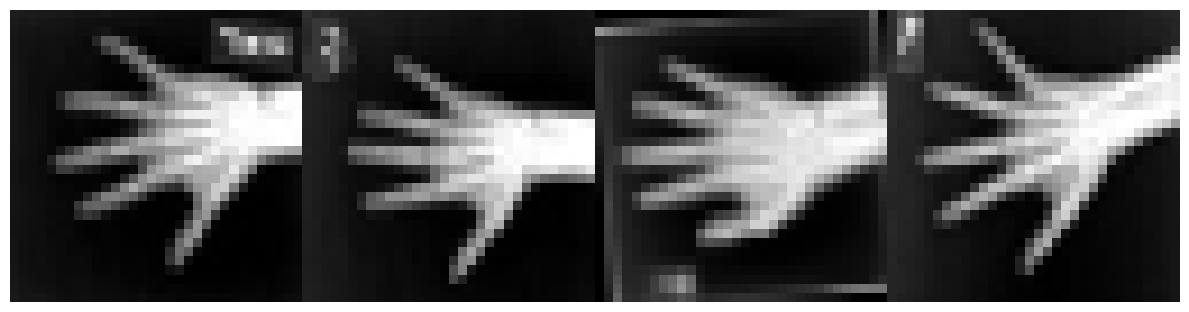

In [4]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

## Define model, DDPM Scheduler and Inferer

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nets.DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(32, 64, 64),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=32,
    norm_num_groups=8,
)
model.to(device)

num_train_timesteps=100
scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)
DDPMScheduler()
optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-4)

inferer = DiffusionInferer(scheduler)

## Training

Epoch 5: 100%|████████████| 32/32 [00:18<00:00,  1.77it/s, loss=0.083]
/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/monai/data/__init__.py:127: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the onl

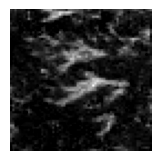

100%|██████████| 100/100 [00:01<00:00, 71.54it/s]


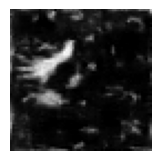

100%|██████████| 100/100 [00:01<00:00, 74.78it/s]


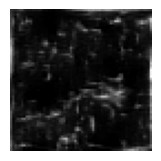

100%|██████████| 100/100 [00:01<00:00, 71.30it/s]


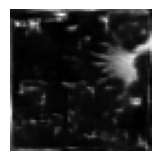

train completed, total time: 369.0812120437622.


In [6]:
n_epochs = 20
val_interval = 5
epoch_loss_list = []
val_epoch_loss_list = []

# setting for Auto Mixed Precision (AMP)
scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch+1}")
    ## Training ##
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        # setting for Auto Mixed Precision (AMP)
        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))
    ## Validation ##
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        noise = torch.randn((1, 1, 64, 64))
        noise = noise.to(device)
        scheduler.set_timesteps(num_inference_steps=num_train_timesteps)
        with autocast(enabled=True):
            image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

## DDPM Visualization

100%|██████████| 100/100 [00:01<00:00, 72.04it/s]


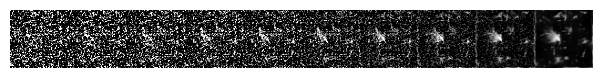

In [7]:
def ddpm_vis():
    model.eval()
    noise = torch.randn((1, 1, 64, 64))
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=num_train_timesteps)
    with autocast(enabled=True):
        image, intermediates = inferer.sample(
            input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=num_train_timesteps//10
        )

    chain = torch.cat(intermediates, dim=-1)

    plt.style.use("default")
    plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.show()

ddpm_vis()

100%|██████████| 100/100 [00:01<00:00, 73.09it/s]


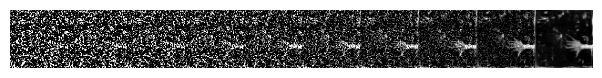

In [8]:
ddpm_vis()